# 2019-02-03 - Analyser des fichiers kwik
Les fichiers kwik sont les formats sortis par l'openEphys GUI. Le détail des fichiers : https://github.com/klusta-team/kwiklib/wiki/Kwik-format

Le github pour les outils : https://github.com/open-ephys/analysis-tools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import KwikTools as kt

In [2]:
dataset = kt.load('ephy_data/2019-01-31_15-04-47_A001/experiment1_100.raw.kwd',
       'all')

In [3]:
dataset

{'info': {'0': <Attributes of HDF5 object at 139721786921736>},
 'data': {'0': <HDF5 dataset "data": shape (1907400, 43), type "<i2">},
 'channel_bit_volts': {'0': <HDF5 dataset "channel_bit_volts": shape (43,), type "<f4">},
 'timestamps': {'0': array([363.16      , 363.16003333, 363.16006667, ..., 426.7399    ,
         426.73993333, 426.73996667])}}

HDF is a bit weird in its dictionnary structure, so let's define a few variables :

In [4]:
info = dataset['info']['0']
data = dataset['data']['0']
channels = dataset['channel_bit_volts']['0']
timestamps = dataset['timestamps']['0']

First, the timestamps :

In [5]:
print('Timestamps shape', timestamps.shape)
print('Timestamps range from %s to %s' % (timestamps.min(), timestamps.max()))
print('Which should be %s seconds' %(timestamps.max() - timestamps.min()))

Timestamps shape (1907400,)
Timestamps range from 363.16 to 426.73996666666665
Which should be 63.57996666666662 seconds


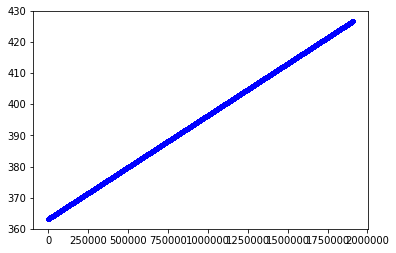

In [6]:
plt.plot(timestamps, '.b')

Then the channels :

In [7]:
channels.shape

(43,)

In [8]:
chans = 0
extras = 0
for chan in channels :
    if chan > .1 : chans +=1
    else : extras +=1

In [9]:
print('There are %s recording channels and %s digital channels\
, one of which must be the photodiode' % (chans, extras))

There are 32 recording channels and 11 digital channels, one of which must be the photodiode


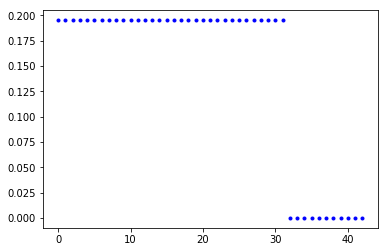

In [10]:
plt.plot(channels, '.b')

And now the actual data

In [11]:
data.shape

(1907400, 43)

In [12]:
data = np.asarray(data)
data = data.swapaxes(0,-1)

In [13]:
data.shape

(43, 1907400)

Text(0.5, 1.0, "Cool it's as noisy as I remember it from patch clamp")

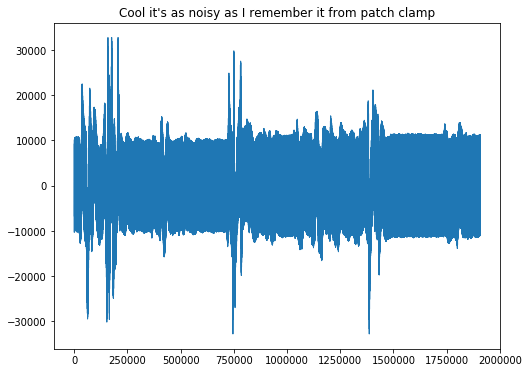

In [14]:
plt.figure(figsize = (8,6))
plt.plot(data[0], linewidth = 1)
plt.title("Cool it's as noisy as I remember it from patch clamp")

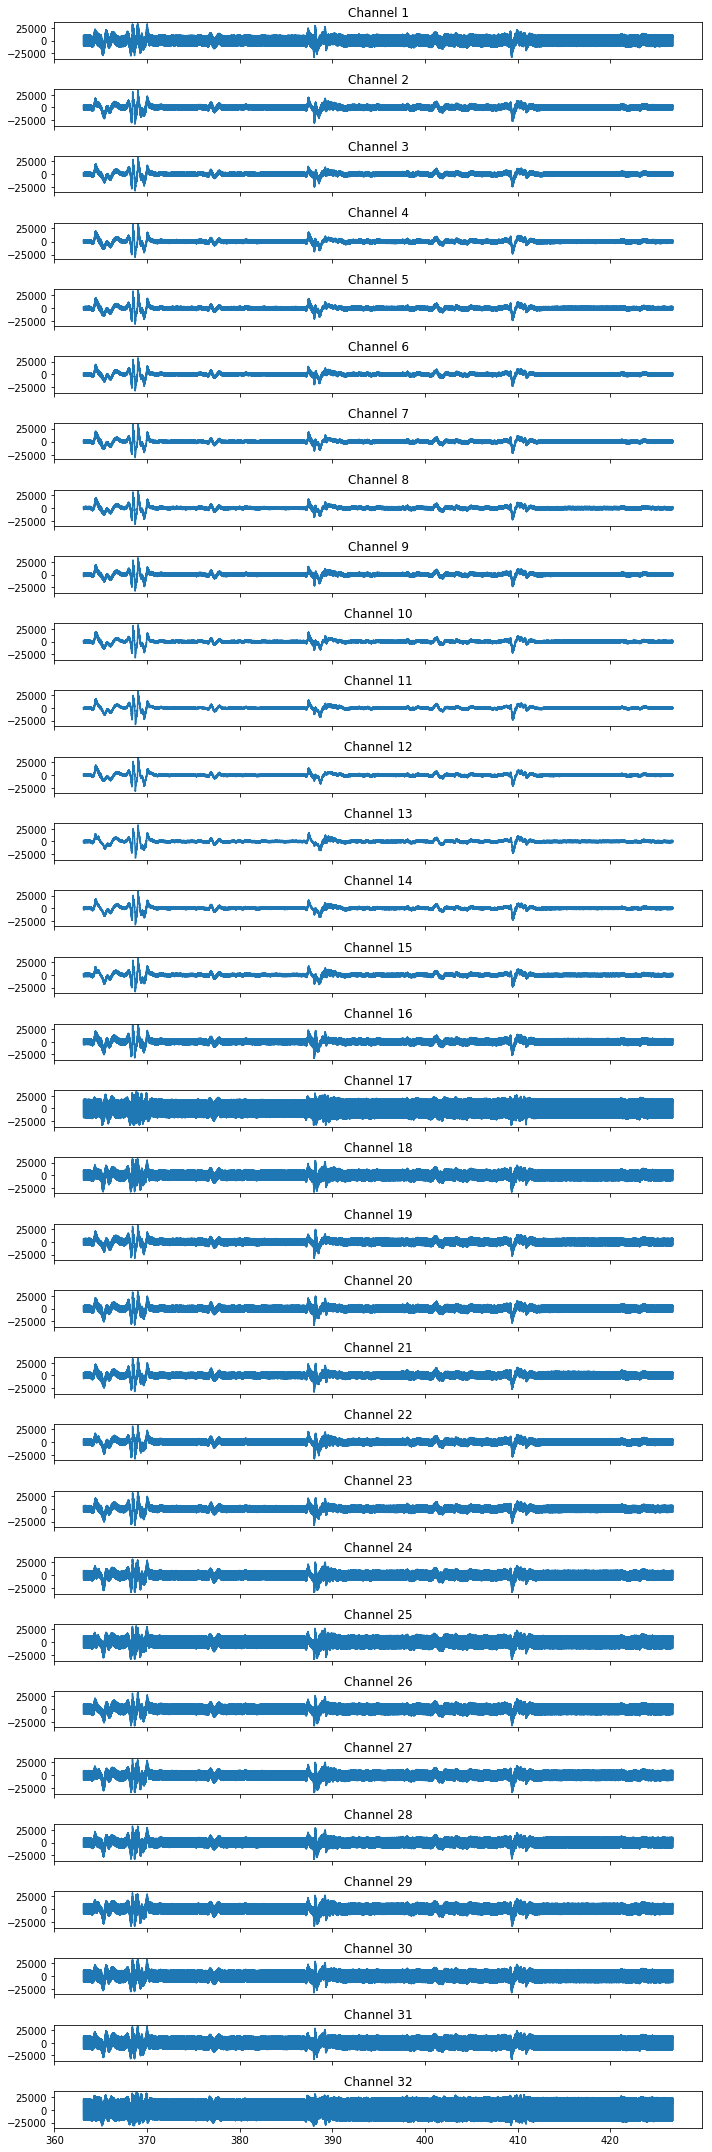

In [15]:
fig, axs = plt.subplots(chans,1, figsize = (10,30))

for chan in range(chans):
    axs[chan].plot(timestamps[::10], data[chan][::10])
    if chan != chans-1 :
        axs[chan].set_xticklabels('')
    axs[chan].set_title('Channel %s' % (chan+1))
plt.tight_layout()

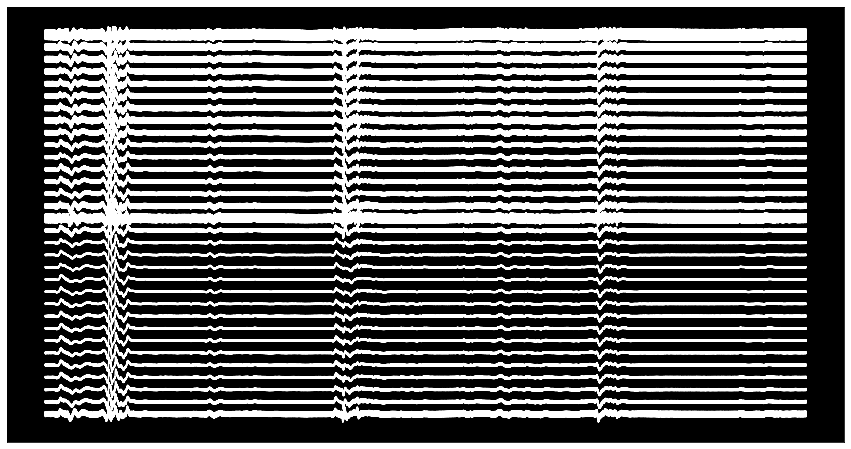

In [16]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.set_facecolor('black')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

colors=plt.cm.autumn(np.linspace(0,.8,chans))

for channel in range(chans):
    plt.plot(data[channel][::100]+channel*50000, zorder = chans-channel,
            color = 'white')
    
    '''plt.fill_between(np.linspace(0, len(st_levels[0]), len(st_levels[0])),
                     tests[channel]+channel/10, channel/9,
                     facecolor='r',
                     zorder=channel)'''
plt.show()

Now to find the photodiode

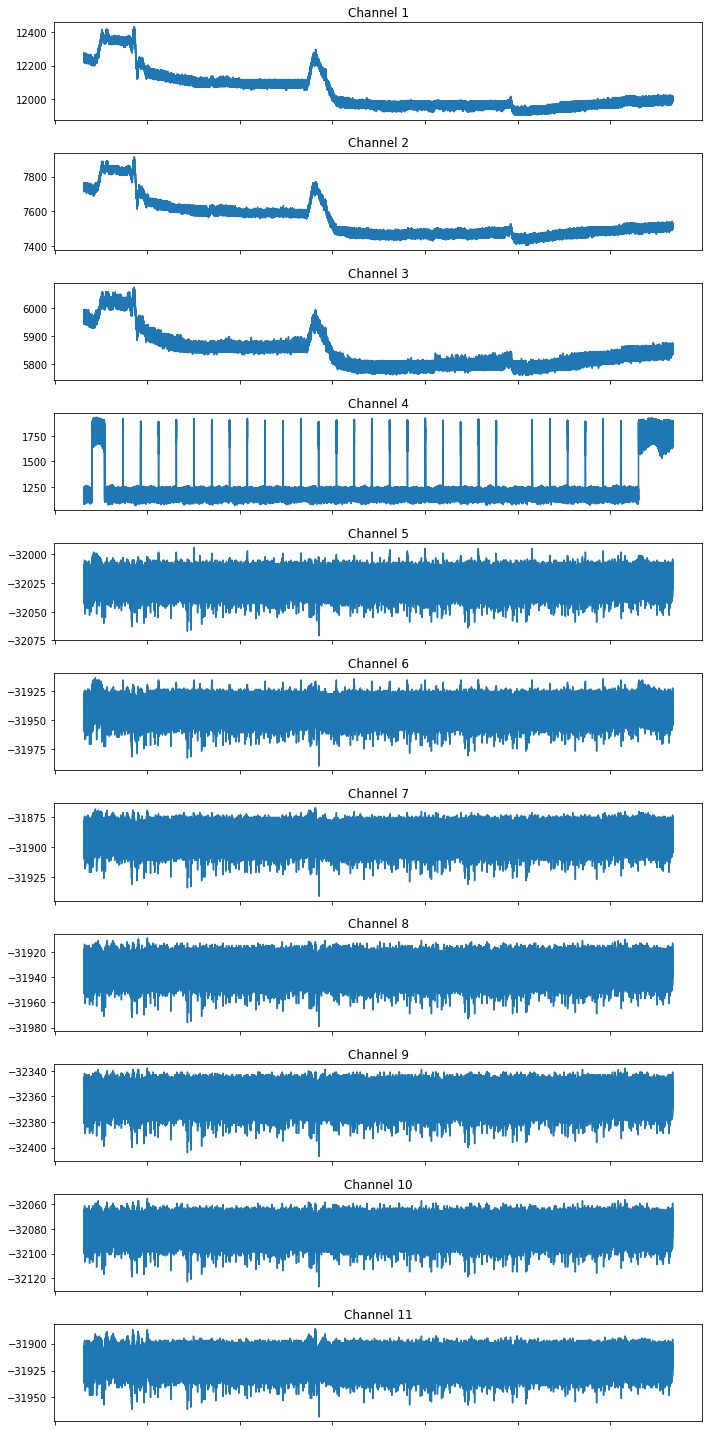

In [17]:
fig, axs = plt.subplots(extras,1, figsize = (10,20))

for chan in range(extras):
    axs[chan].plot(timestamps[::10], data[chans+chan][::10])
    if chan != chans-1 :
        axs[chan].set_xticklabels('')
    axs[chan].set_title('Channel %s' % (chan+1))
plt.tight_layout()

Now we can try to sync analog chan 4 with a random channel

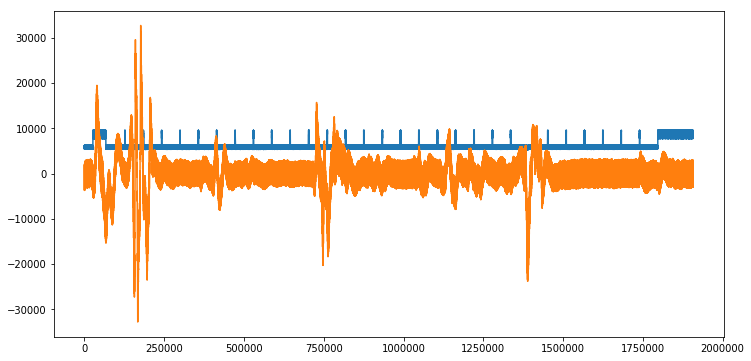

In [18]:
plt.figure(figsize = (12,6))

photodiode_data = data[chans+3]
plt.plot(photodiode_data*5)
plt.plot(data[5])

In [19]:
def spike_chunk_detector(signal, times, threshold, timeframe, verbose = False):
    '''
    On a given analogsignal array, detects pseudo-spikes by clustering above-threshold times
    into groups, given a timeframe(ms) and a threshold(mV)
    
    Ideal timeframes are approx. that of the oscillation period of the network
    '''
    
    #working lists
    chunking_list = []
    chunk_list = []
    
    trues = (signal>threshold)
    
    for it, a in enumerate(trues):
        if a == True : 
            chunking_list.append(times[it])
            
    chunking_list = np.squeeze(chunking_list)
    print(chunking_list)
    print(chunking_list.shape)
    for it, a in enumerate(chunking_list):
        if it > 5 and chunking_list[it-1]+timeframe < chunking_list[it]: #discard first few hits to be safe on initialisation nois
            chunk_list.append(chunking_list[it-1])
            if verbose : print('Found cluster at %s ms' % chunking_list[it-1])
                
    if verbose : print('Found total of %s cluster(s)' % len(chunk_list))
    return chunk_list

In [20]:
spike_chunk_detector(photodiode_data, timestamps, photodiode_data.mean(), 20000, True)

[363.16293333 363.16296667 363.163      ... 426.7399     426.73993333
 426.73996667]
(222226,)
Found total of 0 cluster(s)


[]

In [21]:
signal = photodiode_data
threshold = 1.5*photodiode_data.mean()
times = timestamps
timeframe = 120

trues = (signal>threshold)
chunking_list = []
chunk_list = []
for it, a in enumerate(trues):
    if a == True : 
        chunking_list.append(times[it])

chunking_list = np.asarray(chunking_list)

it = 0
for datapoint in chunking_list:
    try :
        it +=1
        if it > 10 : #discard first few hits to be safe on initialisation nois
            if chunking_list[it]+1 < chunking_list[it+timeframe]: 
                chunk_list.append(chunking_list[it-1])
                it += timeframe
                print('Found cluster at %s' % chunking_list[it])
    except IndexError: 
        print('Done chunking')
        break

print('Found total of %s cluster(s)' % len(chunk_list))

Found cluster at 367.3779333333333
Found cluster at 369.29583333333335
Found cluster at 371.22386666666665
Found cluster at 373.1419
Found cluster at 375.05993333333333
Found cluster at 376.9746
Found cluster at 378.9004
Found cluster at 380.8219
Found cluster at 382.73086666666666
Found cluster at 384.65883333333335
Found cluster at 386.60136666666665
Found cluster at 388.50623333333334
Found cluster at 390.41403333333335
Found cluster at 392.33093333333335
Found cluster at 394.24783333333335
Found cluster at 396.16473333333334
Found cluster at 398.08166666666665
Found cluster at 399.99856666666665
Found cluster at 401.91546666666665
Found cluster at 403.83236666666664
Found cluster at 405.74926666666664
Found cluster at 407.66616666666664
Found cluster at 411.54996666666665
Found cluster at 413.4679
Found cluster at 415.3872
Found cluster at 417.3071
Found cluster at 419.2266666666667
Found cluster at 421.1456333333333
Found cluster at 423.0647333333333
Done chunking
Found total of 2

<IPython.core.display.Javascript object>


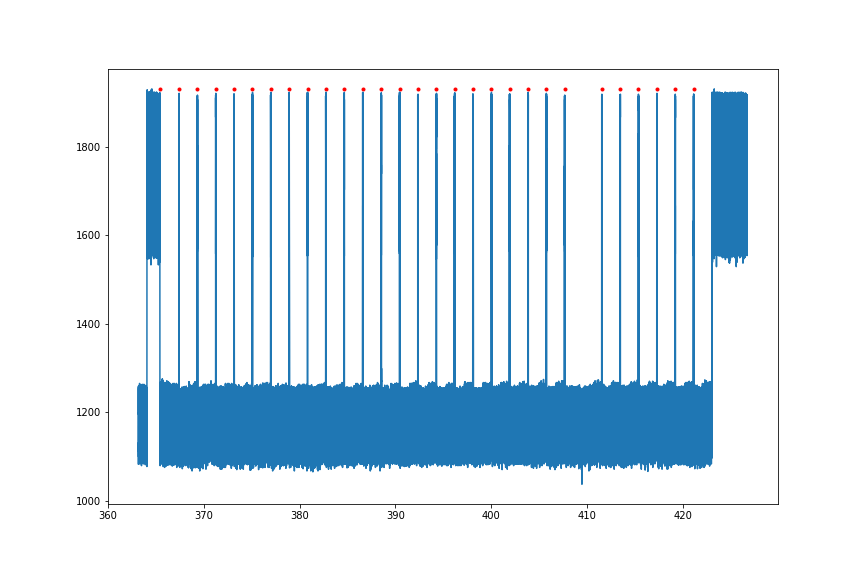

In [37]:
plt.figure(figsize = (12,8))
plt.plot(chunk_list, np.linspace(photodiode_data.max(), photodiode_data.max(), len(chunk_list)), '.r')
plt.plot(timestamps, photodiode_data)

Now we can visualize a signal from the channels for each separate photodiode tick

Visualizing signal from 371.22386666666665s to 369.29583333333335s, lasting 1.9280333333333033s
Array wise, the points range from 184075 to 241916 in the data


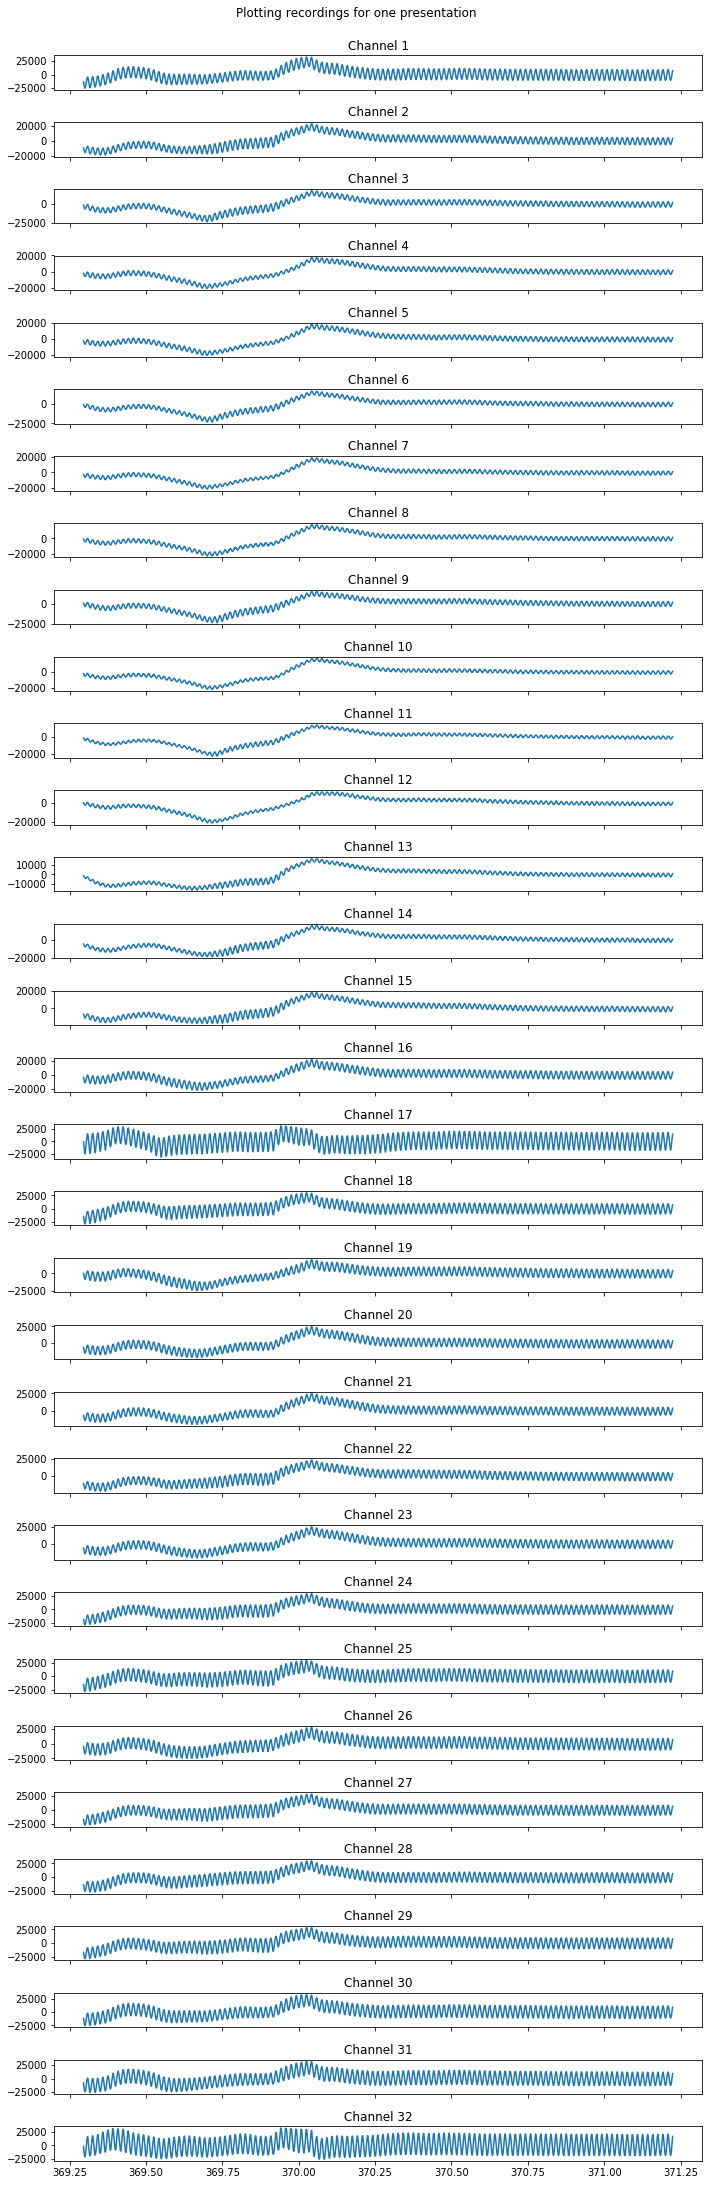

In [40]:
block_to_see = 2

one_particular_presentation = chunk_list[block_to_see+1]-chunk_list[block_to_see]
print('Visualizing signal from %ss to %ss, lasting %ss' % (chunk_list[block_to_see+1],
                                                           chunk_list[block_to_see],
                                                           one_particular_presentation))

time_beg = int(np.where(timestamps == chunk_list[block_to_see])[0])
time_end = int(np.where(timestamps == chunk_list[block_to_see+1])[0])
print('Array wise, the points range from %s to %s in the data' % (time_beg, time_end))

fig, axs = plt.subplots(chans,1, figsize = (10,30))

for chan in range(chans):
    axs[chan].plot(timestamps[time_beg:time_end], data[chan][time_beg:time_end])
    if chan != chans-1 :
        axs[chan].set_xticklabels('')
    axs[chan].set_title('Channel %s' % (chan+1))
plt.suptitle('Plotting recordings for one presentation', y = 1.01)
plt.tight_layout()